# Neural Network with Bag of Words

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm

tqdm.pandas() # To use progress_apply and better visualize the progress

from notebooks.models.tokenizers import CustomTokenizer

In [2]:
# Load dataset.csv into a pandas dataframe
df = pd.read_csv('../data/dataset.csv', index_col=0)

# Shuffle dataset
df = df.sample(frac=1)

df.head()

,id,url,title,text,category
128044,39248502,https://en.wikipedia.org/wiki/Mario%20Party%3A...,Mario Party: Island Tour,is a party video game developed by NDcube and ...,video games
46880,10033684,https://en.wikipedia.org/wiki/Ihringen,Ihringen,Ihringen is a town in the district of Breisgau...,war
6428,511023,https://en.wikipedia.org/wiki/HOME%20STAR,HOME STAR,"HOME STAR, (also spelled HOMESTAR), informally...",politics
186797,63410653,https://en.wikipedia.org/wiki/Enthroned%20Mado...,Enthroned Madonna and Child with Saints Paul a...,The Enthroned Madonna and Child with Saints Pa...,art
133650,41206030,https://en.wikipedia.org/wiki/Vengalrao%20Gott...,Vengalrao Gottimukula,Vengal Rao Gottimukula (born 27 November 1960)...,politicians


## Bag of Words


In [3]:
size = 10_000

In [4]:
X = df['text'][:size]
y = df['category'][:size]

X.head()

128044    is a party video game developed by NDcube and ...
46880     Ihringen is a town in the district of Breisgau...
6428      HOME STAR, (also spelled HOMESTAR), informally...
186797    The Enthroned Madonna and Child with Saints Pa...
133650    Vengal Rao Gottimukula (born 27 November 1960)...
Name: text, dtype: object

In [5]:
# We use the custom tokenizer and remove stopwords
tokenizer = CustomTokenizer(remove_stopwords=True)

X_encoded = X.progress_apply(tokenizer.encode)

X_encoded.head()

100%|██████████| 10000/10000 [00:06<00:00, 1646.45it/s]


128044    [34057, 2835, 1847, 8040, 15953, 46511, 4756, ...
46880     [72, 4171, 29018, 6424, 9474, 5395, 285, 70, 2...
6428      [5227, 6917, 11, 320, 19171, 68918, 5105, 9042...
186797    [21341, 2298, 291, 13088, 13767, 1716, 68220, ...
133650    [85, 833, 278, 436, 3524, 342, 1751, 318, 3178...
Name: text, dtype: object

In [6]:
# We get the vocabulary
vocab = set()

for tokens in tqdm(X_encoded):
    for token in tokens:
        vocab.add(token)

vocab_size = len(vocab)
vocab_size

100%|██████████| 10000/10000 [00:00<00:00, 13133.48it/s]


42828

In [7]:
# We create the bag of words

X_encoded = X_encoded.to_frame() 
X_encoded['bow'] = pd.Series(dtype='object')

def create_bow(tokens):
    bow = {}
    for token in tokens:
        if token in bow:
            bow[token] += 1
        else:
            bow[token] = 1
    return bow

X_encoded['bow'] = X_encoded['text'].progress_apply(lambda x: create_bow(x))

X_encoded.head()

100%|██████████| 10000/10000 [00:00<00:00, 17034.82it/s]


,text,bow
128044,"[34057, 2835, 1847, 8040, 15953, 46511, 4756, ...","{34057: 1, 2835: 5, 1847: 9, 8040: 2, 15953: 1..."
46880,"[72, 4171, 29018, 6424, 9474, 5395, 285, 70, 2...","{72: 1, 4171: 1, 29018: 2, 6424: 1, 9474: 1, 5..."
6428,"[5227, 6917, 11, 320, 19171, 68918, 5105, 9042...","{5227: 1, 6917: 2, 11: 40, 320: 2, 19171: 1, 6..."
186797,"[21341, 2298, 291, 13088, 13767, 1716, 68220, ...","{21341: 1, 2298: 1, 291: 3, 13088: 2, 13767: 2..."
133650,"[85, 833, 278, 436, 3524, 342, 1751, 318, 3178...","{85: 3, 833: 2, 278: 2, 436: 3, 3524: 3, 342: ..."


## Format the data to be used in PyTorch

In [8]:
label_encoder = LabelEncoder()
classes = np.array(y.values)

integer_encoded = label_encoder.fit_transform(classes) # Transform classes to integers

integer_encoded

array([17, 18, 13, ...,  7, 13, 16])

In [9]:
# We first need to change the bag of words to a vector so that we can transform it to a tensor
vocab_list = list(vocab)
word_to_index = {word: index for index, word in enumerate(vocab_list)}

def bow_to_vector(bow):
    vector = np.zeros(vocab_size)
    for word, count in bow.items():
        index = word_to_index[word]
        vector[index] = count
    return vector

X_vector = X_encoded['bow'].progress_apply(bow_to_vector)

X_vector.head()

100%|██████████| 10000/10000 [00:02<00:00, 4323.14it/s]


128044    [0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
46880     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
6428      [0.0, 3.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, ...
186797    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, ...
133650    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
Name: bow, dtype: object

In [10]:
# Convert to PyTorch tensors

X = np.array(X_vector.tolist()) # Convert to numpy array

X_tensor = torch.tensor(X, dtype=torch.float)
y_tensor = torch.tensor(integer_encoded, dtype=torch.long)

X_tensor.shape, y_tensor.shape

(torch.Size([10000, 42828]), torch.Size([10000]))

In [11]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoader objects
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Logistic Regression Model

In [12]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(vocab_size, num_classes)
    
    def forward(self, x):
        return self.linear(x)

class MultiLayerPerceptron(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class MultiLayerPerceptron2(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_classes):
        super(MultiLayerPerceptron2, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden_dim*2)
        self.dropout1 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.dropout2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)

num_epochs = 20
vocab_size = X_tensor.shape[1]
num_classes = len(set(y.values))

#model = LogisticRegressionModel(vocab_size, num_classes)
model = MultiLayerPerceptron2(vocab_size, 10, num_classes)
print(model)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.005)
#optimizer = optim.AdamW(model.parameters(), lr=0.005)

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs = inputs.float()
        labels = labels.long()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        #nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels)
            all_predictions.extend(predicted)

    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

MultiLayerPerceptron2(
  (fc1): Linear(in_features=42828, out_features=20, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=10, out_features=20, bias=True)
)
Epoch [1/20], Loss: 1.7333
Precision: 0.6193, Recall: 0.6360, F1 Score: 0.6030
Epoch [2/20], Loss: 0.9874
Precision: 0.7411, Recall: 0.7495, F1 Score: 0.7406
Epoch [3/20], Loss: 0.3465
Precision: 0.7635, Recall: 0.7440, F1 Score: 0.7487
Epoch [4/20], Loss: 0.6545
Precision: 0.7298, Recall: 0.7300, F1 Score: 0.7267
Epoch [5/20], Loss: 0.2418
Precision: 0.7655, Recall: 0.7525, F1 Score: 0.7547
Epoch [6/20], Loss: 0.1869
Precision: 0.7522, Recall: 0.7510, F1 Score: 0.7496
Epoch [7/20], Loss: 0.1281
Precision: 0.7678, Recall: 0.7615, F1 Score: 0.7610
Epoch [8/20], Loss: 0.2249
Precision: 0.7743, Recall: 0.7585, F1 Score: 0.7621
Epoch [9/20], Loss: 0.1279
Precision: 0.7534, Recall: 0.7385, F1 Score: 

## Confusion Matrix

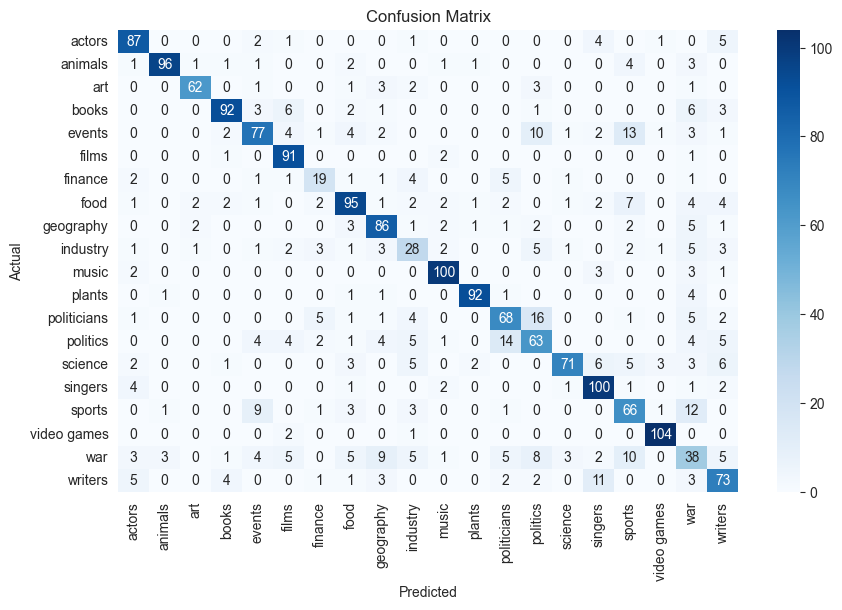

In [13]:
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels)
        all_predictions.extend(predicted)
        
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()